## Revised version
### At the end of this competition, [some kernels](https://www.kaggle.com/cdeotte/3-clusters-per-class-0-975) show that Gaussian Mixture can improve the prediction accuracy from 0.970 to 0.975. Therefore, I revised the previous kernel to add Gaussian Mixture Model.

In [6]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
import warnings
import multiprocessing
from scipy.optimize import minimize  
import time, os
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.mixture import GaussianMixture

warnings.filterwarnings('ignore')

In [7]:
# Load the data
path = os.getcwd()
train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
print(train.shape, test.shape)

(262144, 258) (131073, 257)


#### The main part of this kernel contains 5 steps:
1. Build first QDA model (512 non-linear models with 512 different wheezy-copper-turtle-magic values)
2. Apply Pseudo Labeling and build second model
3. Apply Gaussian Mixture Model when target == 1 or 0.
4. Train the final QDA model with target labels from step 3.
5. Predict and submit

In [8]:
preds = np.zeros(len(test))
oof = np.zeros(len(train))
# 512 models
for i in tqdm_notebook(range(512)):

    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    pipe = Pipeline([('vt', VarianceThreshold(threshold=1.5)), ('scaler', StandardScaler())])
    data2 = pipe.fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]; test3 = data2[train2.shape[0]:]

    # Step 1.
    clf = QuadraticDiscriminantAnalysis(priors = [0.5,0.5])
    clf.fit(train3,train2['target'])
    test_pred = clf.predict_proba(test3)[:,1]
    
    # Step 2
    test_pred[test_pred > 0.96] = 1
    test_pred[test_pred < 0.04] = 0
    index = np.where((test_pred == 1)|(test_pred == 0))
    clf.fit(np.concatenate((train3, test3[index]),axis =0), np.concatenate((train2['target'].values,test_pred[index])) )
    test_pred = clf.predict_proba(test3)[:,1]
    
    # Step 3
    test_pred = test_pred > np.random.uniform(0,1,len(test_pred)) #randomness
    all_y = np.concatenate((train2['target'].values,test_pred))
    clusters = np.zeros((len(data2),6))
    flag = 1
    while flag == 1:
        # FIND THREE TARGET=1 CLUSTERS
        train4 = data2[ np.argwhere(all_y==1).flatten(), :]
        clf_G = GaussianMixture(n_components=3).fit(train4)
        clusters[ np.argwhere(all_y==1).flatten(), 3:] = clf_G.predict_proba(train4)
        # FIND THREE TARGET=0 CLUSTERS
        train4 = data2[ np.argwhere(all_y==0).flatten(), :]
        clf_G = GaussianMixture(n_components=3).fit(train4) #randomness
        clusters[ np.argwhere(all_y==0).flatten(), :3] = clf_G.predict_proba(train4)
        gmm_type = np.argmax(clusters, axis = 1)
        if (pd.Series(gmm_type).value_counts().min()) <= 5: # IF IMBALANCED TRY AGAIN
            flag = 1
        else:
            flag = 0
    
    
    # step 4
    clf = QuadraticDiscriminantAnalysis(priors = [0.167, 0.167, 0.167, 0.167, 0.167, 0.167])
    clf.fit(data2,gmm_type)
    pds = clf.predict_proba(test3)
    pds_train = clf.predict_proba(train3)
    test_pred = pds[:,3]+pds[:,4]+pds[:,5]
    train_pred = pds_train[:,3]+pds_train[:,4]+pds_train[:,5]
    preds[idx2] += test_pred
    oof[idx1] += train_pred
    
auc = roc_auc_score(train['target'],oof)
print(auc)


0.9970209774695118


In [9]:
# STEP 5
sub = pd.read_csv( path + '/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

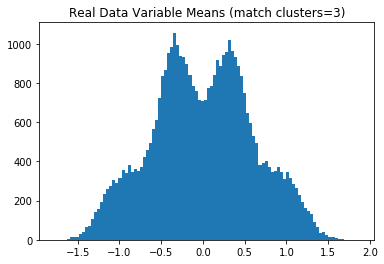

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
centers = np.array([])
for k in range(512):
    
    # REAL DATA
    df_train2 = train[train['wheezy-copper-turtle-magic']==k]
    sel = VarianceThreshold(1.5).fit(df_train2.iloc[:,1:-1])
    df_train3 = sel.transform(df_train2.iloc[:,1:-1])
    X = df_train3
    y = df_train2['target'].values
    
    # COLLECT CENTER COORDINATES
    centers = np.append(centers,np.mean(X[ np.argwhere(y==0).flatten() ,:],axis=0))
    centers = np.append(centers,np.mean(X[ np.argwhere(y==1).flatten() ,:],axis=0))
    
# PLOT CENTER COORDINATES
plt.hist(centers,bins=100)
plt.title('Real Data Variable Means (match clusters=3)')
plt.show()